本次pj选取的是选题1.用CNN网络模型(自己设计或AlexNet或ResNet-18)在MNIST上训练并测试；
我们选取的是ResNet网络。
我们的组员有：王祯祎 20210840015 林大渝 20210840010 李佳睿 20210980076
下面是我们的代码：

In [ ]:
from torchvision import  transforms
from torchvision import  datasets
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
%matplotlib inline

In [16]:
# 残差神经网络 ResNet
class ResidualBlock(nn.Module):  # 保证卷积层输入输出通道数一样
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels=channels
        self.conv1=nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        
    def forward(self,x):
        y=F.relu(self.conv1(x))
        y=self.conv2(y)
        return F.relu(x+y)  # 先求和在激活
    

class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=torch.nn.Conv2d(1,16,kernel_size=5)
        self.conv2=torch.nn.Conv2d(16,32,kernel_size=5)  
        self.mp=torch.nn.MaxPool2d(2)
        
        self.block1=ResidualBlock(16)
        self.block2=ResidualBlock(32)

        self.fc=nn.Linear(512,10)
        
    def forward(self,x):
        in_size=x.size(0)
        x=self.mp(F.relu(self.conv1(x)))
        x=self.block1(x)
        x=self.mp(F.relu(self.conv2(x)))
        x=self.block2(x)
        x=x.view(in_size,-1)
        x=self.fc(x)
        return x
    
def train(epoch,model,optimizer):
    running_loss=0.0
    for batch_idx,data in enumerate(train_loader,0):
        inputs,target = data
    # ----------------------------------------------------
    #  把运算转移到GPU上
        inputs,target = inputs.to(device),target.to(device)
    #----------------------------------------------------
        optimizer.zero_grad()
        
        outputs=model(inputs)
        loss=criterion(outputs,target)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
        if batch_idx % 300 == 299:
#             print('{},{} loss:{}'.format(epoch+1,batch_idx+1,running_loss/300))
            if batch_idx==899: record_loss=running_loss/300
            running_loss=0.0
    return record_loss
            
def test(model,optimizer):
    correct=0
    total=0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
        # ----------------------------------------------------
        #  把运算转移到GPU上
            images,labels = images.to(device),labels.to(device)
        #----------------------------------------------------
            outputs=model(images)
            _,predicted=torch.max(outputs.data,dim=1)  # 返回的是 （每一行的最大值，该最大值的下标）
            total+=labels.size(0)  # 预测样本个数
            correct+=(predicted==labels).sum().item()  # 相等就是真，真就是1
    print('acc:',correct/total)
    return correct/total


def run(model,optimizer):  # 返回 测试集上准确率列表l1，每次epoch结束后在训练集上的loss组成的列表，作图用
    acc=[]
    loss=[]
    for epoch in range(100):
        loss.append(train(epoch,model,optimizer))
        acc.append(test(model,optimizer))
    print('测试集上准确率',acc)
    print('loss',loss)
    return acc,loss



    
if __name__=='__main__':

    batch_size=64
    trans1=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])  
    # 神经网络希望input在(0,1)之间，transform的作用是将 PIL Image0~255 转化为tensor ∈ （0,1）
    # 同时通道作为第一维的特征
    #在做归一化，0.1307为均值，0.3081为标准差
    train_dataset=datasets.MNIST(root='../data',train=True,download=True,transform=trans1)
    test_dataset=datasets.MNIST(root='../data',train=False,download=True,transform=trans1)

    train_loader=DataLoader(train_dataset,shuffle=False,batch_size=batch_size)
    test_loader=DataLoader(test_dataset,shuffle=False,batch_size=batch_size)

    criterion=torch.nn.CrossEntropyLoss()
    
#----------------------------------------------------
# #  把运算转移到GPU上
#     device=torch.device('cuda:0'if torch.cuda.is_available() else "cpu")
#     model.to(device)
#----------------------------------------------------
    print("------------------SGDM--------------------")
    t0=time.process_time()
    model1=Net()
    device=torch.device('cuda:0'if torch.cuda.is_available() else "cpu")
    model1.to(device)
    optimizer1=optim.SGD(model1.parameters(),lr=0.01,momentum=0.5)
    sgd_acc,sgd_loss=run(model1,optimizer1)
    print('耗时为：'+str(time.process_time()-t0))
    print("------------------SGD--------------------")
    t1=time.process_time()
    model2=Net()
    device=torch.device('cuda:0'if torch.cuda.is_available() else "cpu")
    model2.to(device)
    optimizer2=optim.SGD(model2.parameters(),lr=0.01,momentum=0)
    sgdm_acc,sgdm_loss=run(model2,optimizer2)
    print('耗时为：'+str(time.process_time()-t1))
    print("------------------Adagrad--------------------")
    t2=time.process_time()
    model3=Net()
    device=torch.device('cuda:0'if torch.cuda.is_available() else "cpu")
    model3.to(device)
    optimizer3=optim.Adagrad(model3.parameters(),lr=0.01, lr_decay=0, weight_decay=0)
    adagrad_acc,adagrad_loss=run(model3,optimizer3)
    print('耗时为：'+str(time.process_time()-t2))
#     print("------------------Rprop--------------------")
#     t3=time.process_time()
#     model4=Net()
#     device=torch.device('cuda:0'if torch.cuda.is_available() else "cpu")
#     model4.to(device)
#     optimizer4=optim.Rprop(model4.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
#     rms_acc,rms_loss=run(model4,optimizer4)
#     print('耗时为：'+str(time.process_time()-t3))
    print("------------------Adam--------------------")
    t4=time.process_time()
    model5=Net()
    device=torch.device('cuda:0'if torch.cuda.is_available() else "cpu")
    model5.to(device)
    optimizer5=optim.Adam(model5.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    adam_acc,adam_loss=run(model5,optimizer5)
    print('耗时为：'+str(time.process_time()-t4))
    

------------------SGDM--------------------
acc: 0.9682
acc: 0.9768
acc: 0.9808
acc: 0.9837
acc: 0.9856
acc: 0.9875
acc: 0.9879
acc: 0.9882
acc: 0.9887
acc: 0.9885
acc: 0.9892
acc: 0.9892
acc: 0.9893
acc: 0.9895
acc: 0.9895
acc: 0.9894
acc: 0.9891
acc: 0.9891
acc: 0.989
acc: 0.9885
acc: 0.9884
acc: 0.9884
acc: 0.9884
acc: 0.9882
acc: 0.988
acc: 0.988
acc: 0.9881
acc: 0.9869
acc: 0.9858
acc: 0.9869
acc: 0.9872
acc: 0.988
acc: 0.9883
acc: 0.9876
acc: 0.9883
acc: 0.9887
acc: 0.9893
acc: 0.9887
acc: 0.9892
acc: 0.9895
acc: 0.9897
acc: 0.9901
acc: 0.9902
acc: 0.9902
acc: 0.9902
acc: 0.9904
acc: 0.9903
acc: 0.9904
acc: 0.9903
acc: 0.9903
acc: 0.9902
acc: 0.9902
acc: 0.9902
acc: 0.9903
acc: 0.9903
acc: 0.9903
acc: 0.9903
acc: 0.9904
acc: 0.9904
acc: 0.9903
acc: 0.9903
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9903
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9904
acc: 0.9903
a

In [17]:
# 保存adam作为optimizer的Resnet模型
# 为了避免使用新版pytorch经常会遇到与旧版不同用法而导致的问题，采用以下方式储存与读取模型
torch.save({'state_dict': model5.state_dict()}, 'checkpoint.pth.tar')

# 读取
model_load = Net()
checkpoint = torch.load('checkpoint.pth.tar')
model_load.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


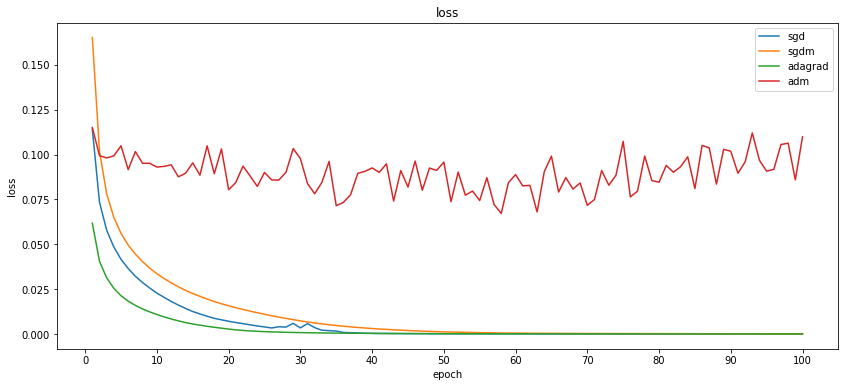

In [26]:
# 作不同优化器下loss图
x = list(int(i) for i in range(1,len(sgd_loss)+1))
print(x)
fig,ax = plt.subplots(figsize=(14,6))

ax.plot(x,sgd_loss,label='sgd')
ax.plot(x,sgdm_loss,label='sgdm')
ax.plot(x,adagrad_loss,label='adagrad')
ax.plot(x,adam_loss,label='adm')
# ax.plot(x,rms_loss,label='RMSProp')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('loss')

x_major_locator=MultipleLocator(10)
ax.xaxis.set_major_locator(x_major_locator)

ax.legend()
plt.show()


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


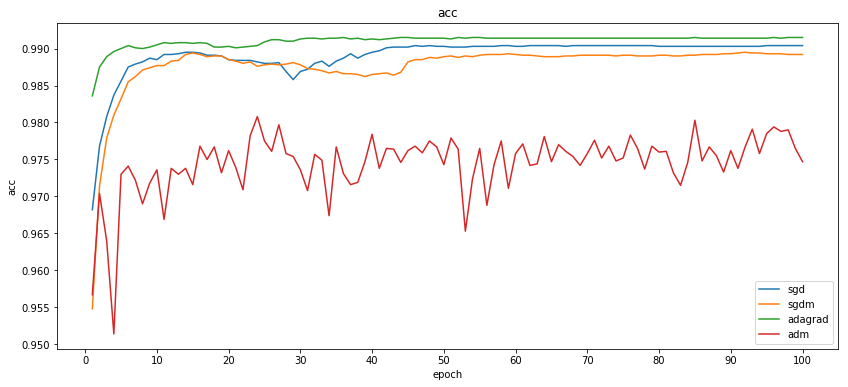

In [27]:
# 作不同优化器下ACC 图形
x = list(int(i) for i in range(1,len(sgd_acc)+1))
print(x)
fig,ax = plt.subplots(figsize=(14,6))

ax.plot(x,sgd_acc,label='sgd')
ax.plot(x,sgdm_acc,label='sgdm')
ax.plot(x,adagrad_acc,label='adagrad')
ax.plot(x,adam_acc,label='adm')
# ax.plot(x,rms_acc,label='RMSProp')

ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('acc')

x_major_locator=MultipleLocator(10)
ax.xaxis.set_major_locator(x_major_locator)

ax.legend()
plt.show()

In [20]:
# 下面几个函数是对结果进行评估的，只针对adam作为optimizer的Resnet模型
def get2list(model):
    # 返回预测结果的列表pre_l和真实标签列表lab_l
    l1=[]
    pre_l=[]
    
    l2=[] 
    lab_l=[]
    
    correct=0
    total=0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
        # ----------------------------------------------------
        #  把运算转移到GPU上
            images,labels = images.to(device),labels.to(device)
        #----------------------------------------------------
            outputs=model(images)
            
            _,predicted=torch.max(outputs.data,dim=1)  # 返回的是 （每一行的最大值，该最大值的下标）
            total+=labels.size(0)  # 预测样本个数
            correct+=(predicted==labels).sum().item()  # 相等就是真，真就是1
            
            l1.append(predicted.cpu().numpy().tolist()) 
            l2.append(labels.cpu().numpy().tolist())  
    for item in l1:
        for data in item:
            pre_l.append(data)
    for item in l2:
        for data in item:
            lab_l.append(data)
    return pre_l,lab_l

pre_l,lab_l=get2list(model5)  
print(pre_l[:10])  # 打印一下前十个预测值看一下

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [21]:
# 得到混淆矩阵
def return_confusion(pre_l,lab_l):
    confusion=np.array([0]*100).reshape(10,10)
    for i,j in zip(pre_l,lab_l):
        confusion[i][j]+=1
    
    print(confusion)
    return confusion
    
confusion=return_confusion(pre_l,lab_l)

[[ 971    3    5    0    0    2    9    1    6    3]
 [   0 1128    8    2    2    0    3   10    1    2]
 [   1    0 1005    3    1    1    0   16    3    0]
 [   1    1    4  976    0    6    0    2    2    2]
 [   0    1    1    0  958    0    1    0    1   12]
 [   0    1    0   24    0  877    8    1    9    9]
 [   3    1    2    0    5    1  931    0    2    0]
 [   0    0    2    2    6    1    0  994    1   10]
 [   3    0    5    3    2    2    5    2  946   10]
 [   1    0    0    0    8    2    1    2    3  961]]


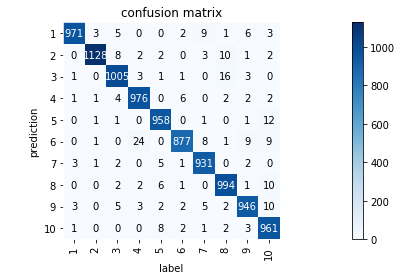

In [22]:
# 混淆矩阵可视化
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.axis("equal")

    ax = plt.gca()
    left, right = plt.xlim()
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")
        

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if num > thresh else "black")
    
    plt.ylabel('prediction')
    plt.xlabel('label')
    
    plt.tight_layout()
    plt.savefig('混淆矩阵热力图.png', transparent=True, dpi=800) 
    
    plt.show()


label = ["{}".format(i) for i in range(1, confusion.shape[0]+1)]
plot_confusion_matrix(confusion, label)

In [23]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def cal_indicators(pre_l,lab_l):

#     w_average=metrics.precision_score(lab_l, pre_l, average='micro')  # 微平均，精确率 两者都是precsion
#     h_average=metrics.precision_score(lab_l, pre_l, average='macro')  # 宏平均，精确率
#     acc=accuracy_score(lab_l, pre_l) #acc
#     recall=metrics.recall_score(lab_l, pre_l, average='micro')
#     f1=metrics.f1_score(lab_l, pre_l, average='weighted')
    
    target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    print(classification_report(lab_l, pre_l, target_names=target_names))
    # 分类报告：precision/recall/fi-score/均值/分类个数
    
cal_indicators(pre_l,lab_l)

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       980
           2       0.98      0.99      0.98      1135
           3       0.98      0.97      0.97      1032
           4       0.98      0.97      0.97      1010
           5       0.98      0.98      0.98       982
           6       0.94      0.98      0.96       892
           7       0.99      0.97      0.98       958
           8       0.98      0.97      0.97      1028
           9       0.97      0.97      0.97       974
          10       0.98      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

